<p align = "center"><strong>GLOBAL SPATIAL AUTOCORRELATION: MORAN’S I <strong></p>

<p><b>By: Jefferson C.</p>

---

#### __Global Moran's Index__
__Def.__

Medida Global de __autocorrelación espacial__ que cuantifica el grado en que los valores de una variable están correlacionados con los valores de unidades espaciales vecinas, de acuerdo con una matriz de pesos espaciales.

El índice toma valores :
- $\to$ __1__ fuerte autocorrelación espacial positiva 

- $\approx$ __0__ ausencia de autocorrelación espacial

- $\to$ __-1__ autocorrelación espacial negativa

__Formula:__

Suma de pesos espaciales 
$$
S_0 = \sum_{i=1}^{n}\sum_{j=1}^{n} w_{ij}
$$

Desviaciones respecto la media
$$z_i = x_i - \bar{x} \qquad z_j = x_j - \bar{x}
\qquad \bar{x}=\frac{1}{n}\sum_{i=1}^{n}x_i$$ 

Índice de Moran

$$ I =
\frac{n}{S_0}\;
\frac{\sum_{i=1}^{n}\sum_{j=1}^{n} w_{ij} z_i z_j}
{\sum_{i=1}^{n} z_i^2}
$$

Valor esperado 

$$E(I) = -\frac{1}{n-1} $$

<p align = 'center'> <em>Bajo el supuesto de aleatoriedad espacial, el valor esperado del índice de Moran es cercano a cero para muestras grandes</em></p>

donde : 
- $w_{ij}$ elemento de la matrix de pesos espaciales $W$
- $x_i$ valor observado de la variable de interés en la unidad espacial $i$.
- $x_j$ valor observado de la variable de interés en la unidad espacial contigua (vecina de $x_i$)
- $n$ número de unidades espaciales.
- $z_i$ valor centrado (no normalizado) de la observación $i$.

__Reference:__
- Spatial Analysis Online. (s.f.). *Global Spatial Autocorrelation (Moran’s I and Geary’s C)*.  
  https://www.spatialanalysisonline.com/HTML/index.html?global_spatial_autocorrelation.htm




__Code :__

In [88]:
# DEPENDENCIES 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
    # Import data (shp)
import geopandas as gpd
    # Weight Matrix
from libpysal.weights import Queen, Rook, W, lag_spatial, w_subset
    # Global index (MORAN'S)
from esda.moran import Moran
    # Warnings
import warnings
import contextlib

def global_moran(
    gdf,
    fields,
    contiguities=("queen", "rook", "bishop"),
    permutations=9999,
    alpha=0.05,
    drop_islands=True,
    standardize_x=True,
    use_index=True,
    style="seaborn-v0_8",
    silence_warnings=True,
    dashboard_field=None,
    figsize=(15, 10),
):
    """
    GLOBAL Moran's I for multiple variables and spatial contiguities
    (Queen / Rook / Bishop).

    Assumptions:
      - gdf is already CLEAN (numeric fields, no NaN/inf values)
      - geometries are valid

    Returns:
      1) results_table : long-format table with Global Moran results
      2) fig           : dashboard (scatterplot + permutation histogram)
      3) out           : dictionary with internal objects
    """

    # BASIC INPUT HANDLING
    if isinstance(fields, str):
        fields = [fields]
    fields = list(fields)

    contiguities = tuple(c.lower().strip() for c in contiguities)
    allowed = {"queen", "rook", "bishop"}
    if any(c not in allowed for c in contiguities):
        raise ValueError(f"contiguities must be in {allowed}")

    # Default dashboard variable
    if dashboard_field is None:
        dashboard_field = fields[0]
    if dashboard_field not in fields:
        raise ValueError("dashboard_field must be inside fields")

    # Warning about index handling (important for islands removal)
    if not use_index:
        warnings.warn(
            "use_index=False may misalign island IDs with gdf.index "
            "when dropping islands. Recommended: use_index=True.",
            UserWarning,
        )

    # CONTEXT MANAGERS (avoid global side effects)
    @contextlib.contextmanager
    def _maybe_style(style_name):
        """
        Temporarily apply a matplotlib style without
        contaminating global rcParams.
        """
        old = plt.rcParams.copy()
        try:
            plt.style.use(style_name)
            yield
        finally:
            plt.rcParams.update(old)

    @contextlib.contextmanager
    def _maybe_warnings(silence):
        """
        Optionally silence common PySAL warnings related
        to disconnected weight matrices and index usage.
        """
        if not silence:
            yield
            return
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                category=UserWarning,
                message=".*weights matrix is not fully connected.*",
            )
            warnings.filterwarnings(
                "ignore",
                category=FutureWarning,
                message=".*use_index.*",
            )
            yield

    # HELPER FUNCTIONS
    def _zscore(x):
        """
        Z-score standardization using population standard deviation (ddof=0).
        If variance is zero, returns a zero vector to avoid numerical issues.
        """
        sd = x.std(ddof=0)
        return (x - x.mean()) / sd if sd > 0 else x * 0.0

    def _build_weights(df):
        """
        Build spatial weight matrices for all requested contiguities:
          - Queen  : shared edge or vertex
          - Rook   : shared edge
          - Bishop : shared vertex only (Queen - Rook)
        """
        wq = Queen.from_dataframe(df, use_index=use_index)
        wr = Rook.from_dataframe(df, use_index=use_index)

        out = {}
        if "queen" in contiguities:
            out["queen"] = wq
        if "rook" in contiguities:
            out["rook"] = wr
        if "bishop" in contiguities:
            ids = list(wq.id_order)
            neighbors = {
                i: list(set(wq.neighbors.get(i, [])) - set(wr.neighbors.get(i, [])))
                for i in ids
            }
            out["bishop"] = W(neighbors, id_order=ids)

        return out

    def _subset_drop_islands(w, df):
        """
        Subset a spatial weights object to match the dataframe
        and optionally remove islands (units with no neighbors).
        """
        ids = list(df.index) if use_index else list(range(len(df)))
        w2 = w_subset(w, ids)

        islands_initial = list(getattr(w2, "islands", []))

        if drop_islands and islands_initial:
            df2 = df.drop(index=islands_initial).copy() if use_index else df.copy()
            ids2 = list(df2.index) if use_index else list(range(len(df2)))
            w2 = w_subset(w, ids2)
            return w2, df2, islands_initial

        return w2, df, islands_initial

    # RESULTS TABLE
    rows = []

    with _maybe_warnings(silence_warnings), _maybe_style(style):

        # Build full weight matrices ONCE
        w_full = _build_weights(gdf)

        # Loop over variables and contiguities
        for field in fields:
            for c in contiguities:

                # Subset weights and optionally drop islands
                w2, df2, islands_initial = _subset_drop_islands(w_full[c], gdf)
                w2.transform = "R"  # row-standardized weights (GeoDa style)

                x = df2[field].to_numpy()
                var_x = float(np.var(x, ddof=0))

                # Degenerate cases: too few observations or zero variance
                if len(x) < 3 or np.std(x, ddof=0) == 0:
                    rows.append(dict(
                        variable=field,
                        contiguity=c.upper(),
                        n=int(len(x)),
                        var_x=var_x,
                        Moran_I=np.nan,
                        E_I=float(-1 / (len(x) - 1)) if len(x) > 1 else np.nan,
                        z_sim=np.nan,
                        p_value_perm=np.nan,
                        significant_alpha=False,
                        permutations=int(permutations),
                        islands_initial=int(len(islands_initial)),
                        islands_removed=int(len(islands_initial)) if drop_islands else 0,
                        islands_remaining=int(len(getattr(w2, "islands", []))),
                        note="n<3 or zero variance",
                    ))
                    continue

                # Global Moran computation
                mi = Moran(x, w2, permutations=permutations)

                rows.append(dict(
                    variable=field,
                    contiguity=c.upper(),
                    n=int(len(x)),
                    var_x=var_x,
                    Moran_I=float(mi.I),
                    E_I=float(mi.EI),
                    z_sim=float(mi.z_sim),
                    p_value_perm=float(mi.p_sim),
                    significant_alpha=bool(mi.p_sim < alpha),
                    permutations=int(permutations),
                    islands_initial=int(len(islands_initial)),
                    islands_removed=int(len(islands_initial)) if drop_islands else 0,
                    islands_remaining=int(len(getattr(w2, "islands", []))),
                    note="",
                ))

        # Build results table
        results_table = pd.DataFrame(rows)

        order = pd.CategoricalDtype(["QUEEN", "ROOK", "BISHOP"], ordered=True)
        results_table["contiguity"] = (
            results_table["contiguity"].astype(str).str.upper().astype(order)
        )
        results_table = (
            results_table.sort_values(["variable", "contiguity"])
            .reset_index(drop=True)
        )

        # DASHBOARD (single variable visualization)
        dash = {}
        kinds = list(contiguities)

        for kind in kinds:
            w2, df2, _ = _subset_drop_islands(w_full[kind], gdf)
            w2.transform = "R"

            x = df2[dashboard_field].to_numpy()
            mi = Moran(x, w2, permutations=permutations)

            x_plot = _zscore(x) if standardize_x else x.copy()
            wx_plot = lag_spatial(w2, x_plot)

            dash[kind] = dict(
                gdf=df2,
                w=w2,
                x=x,
                mi=mi,
                x_plot=x_plot,
                wx_plot=wx_plot,
            )

        # PLOTS
        fig, axes = plt.subplots(len(kinds), 2, figsize=figsize)
        if len(kinds) == 1:
            axes = np.array([axes])

        for r, kind in enumerate(kinds):
            mi = dash[kind]["mi"]
            x_plot = dash[kind]["x_plot"]
            wx_plot = dash[kind]["wx_plot"]

            # Moran scatterplot
            ax_sc = axes[r, 0]
            ax_sc.scatter(x_plot, wx_plot, edgecolor="k", facecolor="none")
            ax_sc.axhline(0, color="gray", linestyle="--", linewidth=1)
            ax_sc.axvline(0, color="gray", linestyle="--", linewidth=1)

            xx = np.linspace(np.min(x_plot), np.max(x_plot), 100)
            ax_sc.plot(xx, mi.I * xx, linewidth=2)

            ax_sc.set_title(
                f"{kind.upper()} — Moran Scatterplot (I={mi.I:.3f})",
                fontweight="bold",
            )
            ax_sc.set_xlabel(
                f"{dashboard_field} ({'std' if standardize_x else 'raw'})"
            )
            ax_sc.set_ylabel("Spatial lag")

            # Permutation histogram
            ax_ph = axes[r, 1]
            ax_ph.hist(mi.sim, bins=30, edgecolor="black")
            ax_ph.axvline(mi.I, linewidth=2)
            ax_ph.set_title(
                f"{kind.upper()} — Permutations (p={mi.p_sim:.4f})",
                fontweight="bold",
            )
            ax_ph.set_xlabel("Moran's I")
            ax_ph.set_ylabel("Frequency")

        fig.suptitle(
            f"GLOBAL MORAN'S I — {dashboard_field}",
            y=1.02,
            fontsize=14,
            fontweight="bold",
        )
        fig.tight_layout()

    out = {"dashboard": dash, "results_table": results_table}
    return results_table, fig, out

In [89]:
# Import data 
gdf = gpd.read_file("../healthindicators/HealthIndicators.shp")

,variable,contiguity,n,var_x,Moran_I,E_I,z_sim,p_value_perm,significant_alpha,permutations,islands_initial,islands_removed,islands_remaining,note
0,Below_evel,QUEEN,77,130.464095,0.456615,-0.013158,6.635225,0.001,True,999,0,0,0,
1,Below_evel,ROOK,77,130.464095,0.465253,-0.013158,6.371950,0.001,True,999,0,0,0,
2,Below_evel,BISHOP,31,76.040499,0.284716,-0.033333,1.400721,0.081,False,999,46,46,0,
3,BirthRate,QUEEN,77,12.290258,0.321203,-0.013158,4.570089,0.001,True,999,0,0,0,
4,BirthRate,ROOK,77,12.290258,0.333674,-0.013158,4.380372,0.001,True,999,0,0,0,
5,BirthRate,BISHOP,31,12.934964,0.040896,-0.033333,0.313332,0.380,False,999,46,46,0,
6,TeenB_Rate,QUEEN,77,779.234225,0.538320,-0.013158,7.272242,0.001,True,999,0,0,0,
7,TeenB_Rate,ROOK,77,779.234225,0.549971,-0.013158,7.651237,0.001,True,999,0,0,0,
8,TeenB_Rate,BISHOP,31,469.851093,0.266631,-0.033333,1.214396,0.112,False,999,46,46,0,
9,Unemp_ment,QUEEN,77,48.806348,0.465670,-0.013158,7.012552,0.001,True,999,0,0,0,


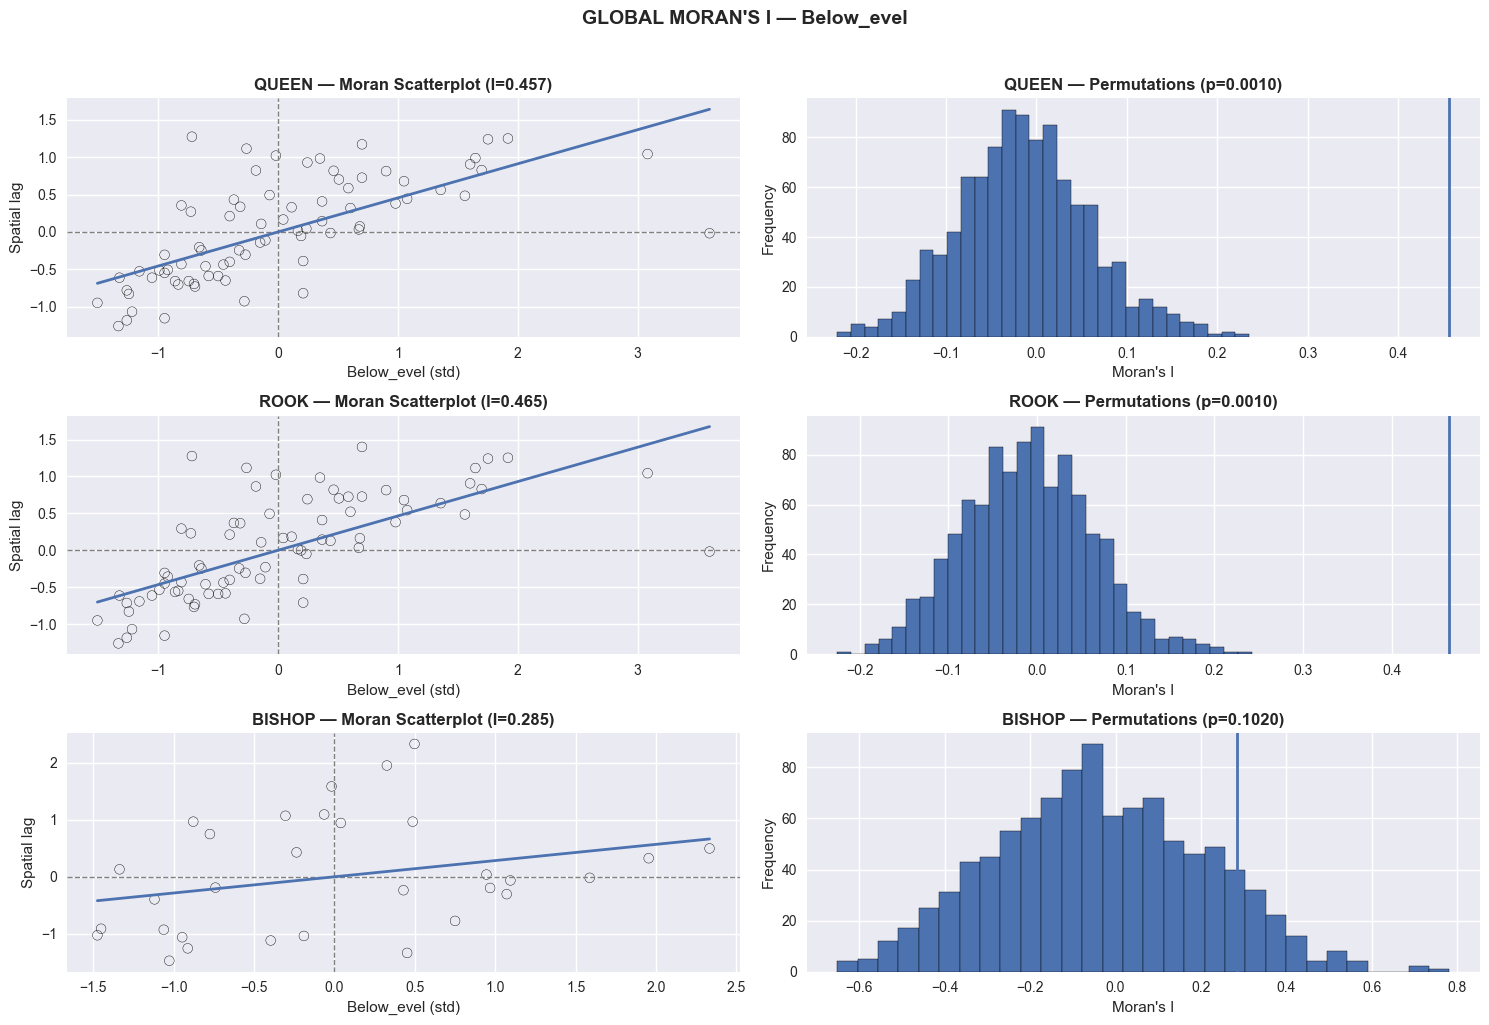

In [90]:
# Inputs 
fields = ["Unemp_ment", "Below_evel", "BirthRate", "TeenB_Rate"]

table, fig, out = global_moran(
    gdf,
    fields,
    permutations=999,
    alpha=0.05,
    dashboard_field="Below_evel",
)

# Outputs
display(table)
plt.show()

---